In [113]:
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
import importlib
import wrftools as wrf
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import genutils as gu
TT = gu.TicTocGenerator()

In [ ]:
importlib.reload(wrf)
importlib.reload(gu)

run='run_CTRL_rr'
# run='run_land_t06_rr'
nph=1 # out per hour
t0=(1*24+1)*nph
tmax=(6*24+1)*nph
dt=1
avgt=6

# run='run_land_t06_rr'
# t0=1
# tmax=25
# dt=1
# avgt=6

force=False

hrs=(np.arange(t0,tmax,dt)/nph).tolist()
flist=wrf.getflist(run)[t0:tmax:dt]

r=wrf.getRcoord(wrf.wopath(run,flist[0]))
dr=(r[1]-r[0])*1000
vr=[wrf.getWRF(run,fname,'vr',vtype='azdpwsmcm',z='full',force=force) for fname in flist]
vt=[wrf.getWRF(run,fname,'vt',vtype='azdpwcm',z='full',force=force) for fname in flist]
Psfc=[wrf.getWRF(run,fname,'P',vtype='az',z=0,force=force) for fname in flist]
P1=[wrf.getWRF(run,fname,'P',vtype='az',z=1,force=force) for fname in flist]

# averaging
vravg,hrsa=gu.avg_list(vr,avgt,hrs)
vtavg,hrsa=gu.avg_list(vt,avgt,hrs)
Psfcavg,hrsa=gu.avg_list(Psfc,avgt,hrs)
P1avg,hrsa=gu.avg_list(Psfc,avgt,hrs)

dPdr=[100*np.gradient(P)/dr for P in Psfcavg]

#smoothing
vravg=[gu.smooth(x,5) for x in vravg] 

Creating: run_CTRL_rr/wrfout_d03_2007-09-02_12:00:00.vr.azdpwsmcm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_12:00:00.vr.dpwsmcm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_12:00:00.vr.sm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_13:00:00.vr.azdpwsmcm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_13:00:00.vr.dpwsmcm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_13:00:00.vr.sm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_14:00:00.vr.azdpwsmcm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_14:00:00.vr.dpwsmcm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_14:00:00.vr.sm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_15:00:00.vr.azdpwsmcm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_15:00:00.vr.dpwsmcm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_15:00:00.vr.sm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_16:00:00.vr.azdpwsmcm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_16:00:00.vr.dpwsmcm.npy
Creating: run_CTRL_rr/wrfout_d03_2007-09-02_16:00:00.vr.sm

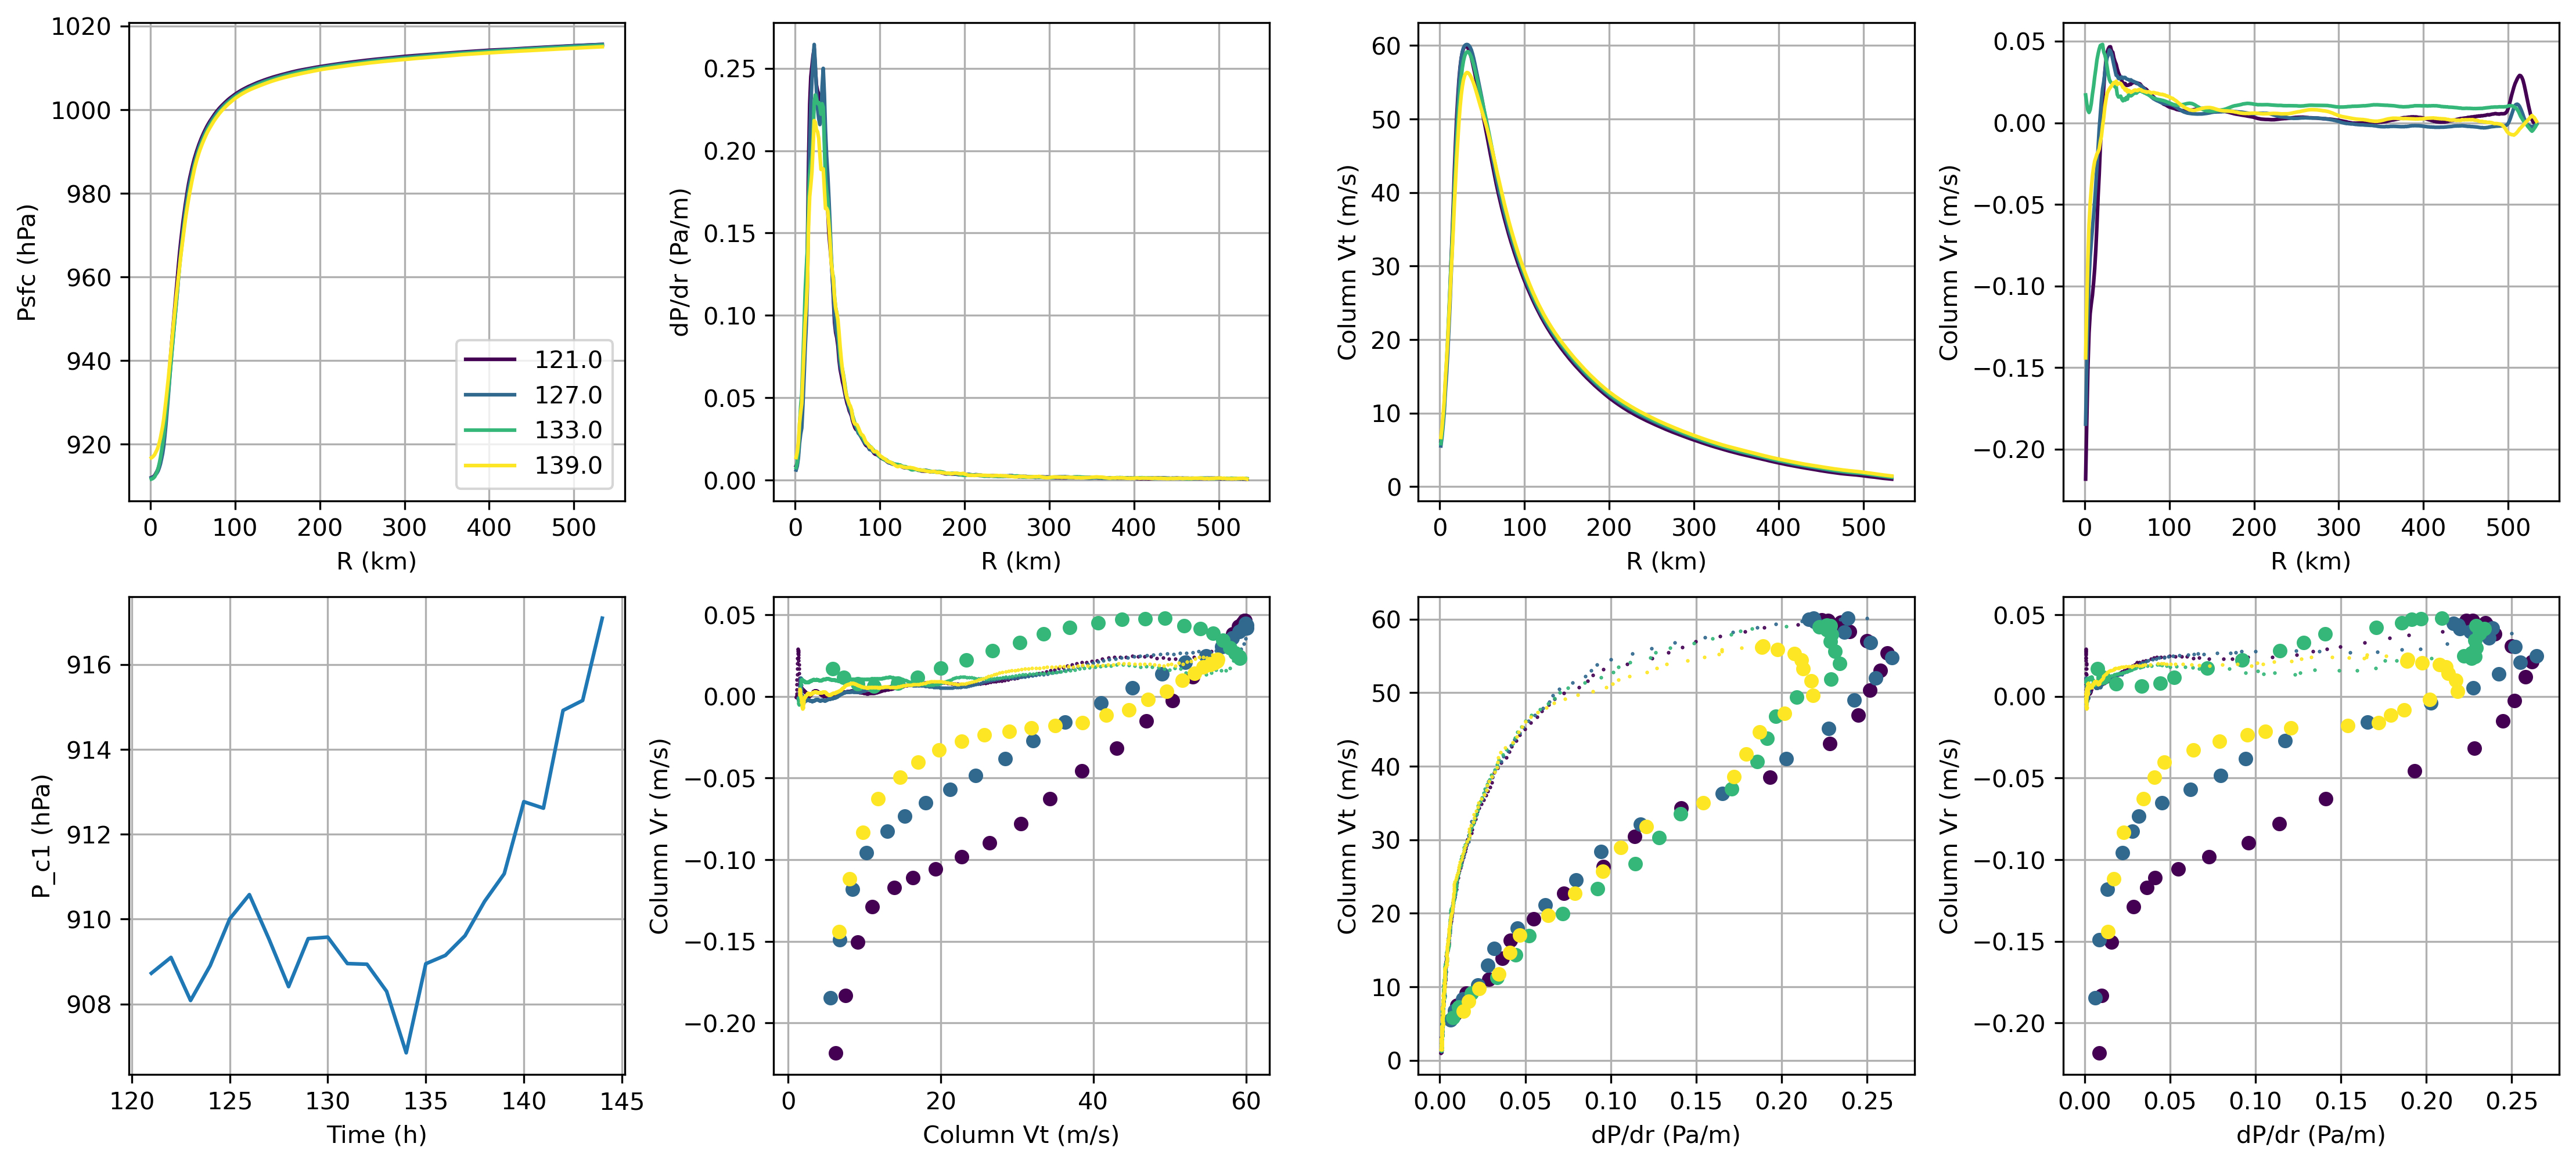

In [115]:
fig,axs=plt.subplots(2,4,figsize=(18,8),dpi=300)
def plot_sub(ax,xs,ys,ylab,ls='-',mk='',xlab='R (km)',rmax=0):
    h=[]
    for n,y in enumerate(ys):
        if type(xs)==list:
            x=xs[n]
        else:
            x=xs        
        if rmax==0:
            ax.plot(x,y,color=cmap(n),ls=ls,marker=mk,ms=1)
        else:
            rin=r<=rmax[n]
            rout=r>rmax[n]
            ax.plot(x[rin],y[rin],color=cmap(n),ls=ls,marker=mk,ms=10)
            ax.plot(x[rout],y[rout],color=cmap(n),ls=ls,marker=mk,ms=1)
        ax.grid(True)
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        
cmap=cm.get_cmap('viridis',len(vravg))

rmax=[r[np.argmax(v)] for v in vtavg]

plot_sub(axs[0,0],r,Psfcavg,'Psfc (hPa)')
plot_sub(axs[0,2],r,vtavg, 'Column Vt (m/s)')
plot_sub(axs[0,3],r,vravg, 'Column Vr (m/s)')
plot_sub(axs[0,1],r,dPdr, 'dP/dr (Pa/m)')

plot_sub(axs[1,2],dPdr,vtavg, 'Column Vt (m/s)',xlab='dP/dr (Pa/m)',ls='',mk='.',rmax=rmax)
plot_sub(axs[1,3],dPdr,vravg, 'Column Vr (m/s)',xlab='dP/dr (Pa/m)',ls='',mk='.',rmax=rmax)
plot_sub(axs[1,1],vtavg,vravg, 'Column Vr (m/s)',xlab='Column Vt (m/s)',ls='',mk='.',rmax=rmax)

# axs[1,0].axis('off')
axs[1,0].plot(hrs,[P[0] for P in P1])
axs[1,0].set_xlabel('Time (h)')
axs[1,0].set_ylabel('P_c1 (hPa)')
axs[1,0].grid(True)
axs[0,0].legend(hrsa);
plt.subplots_adjust(wspace=0.3)

Text(0.5, 0.98, 'Vr col 24hr')

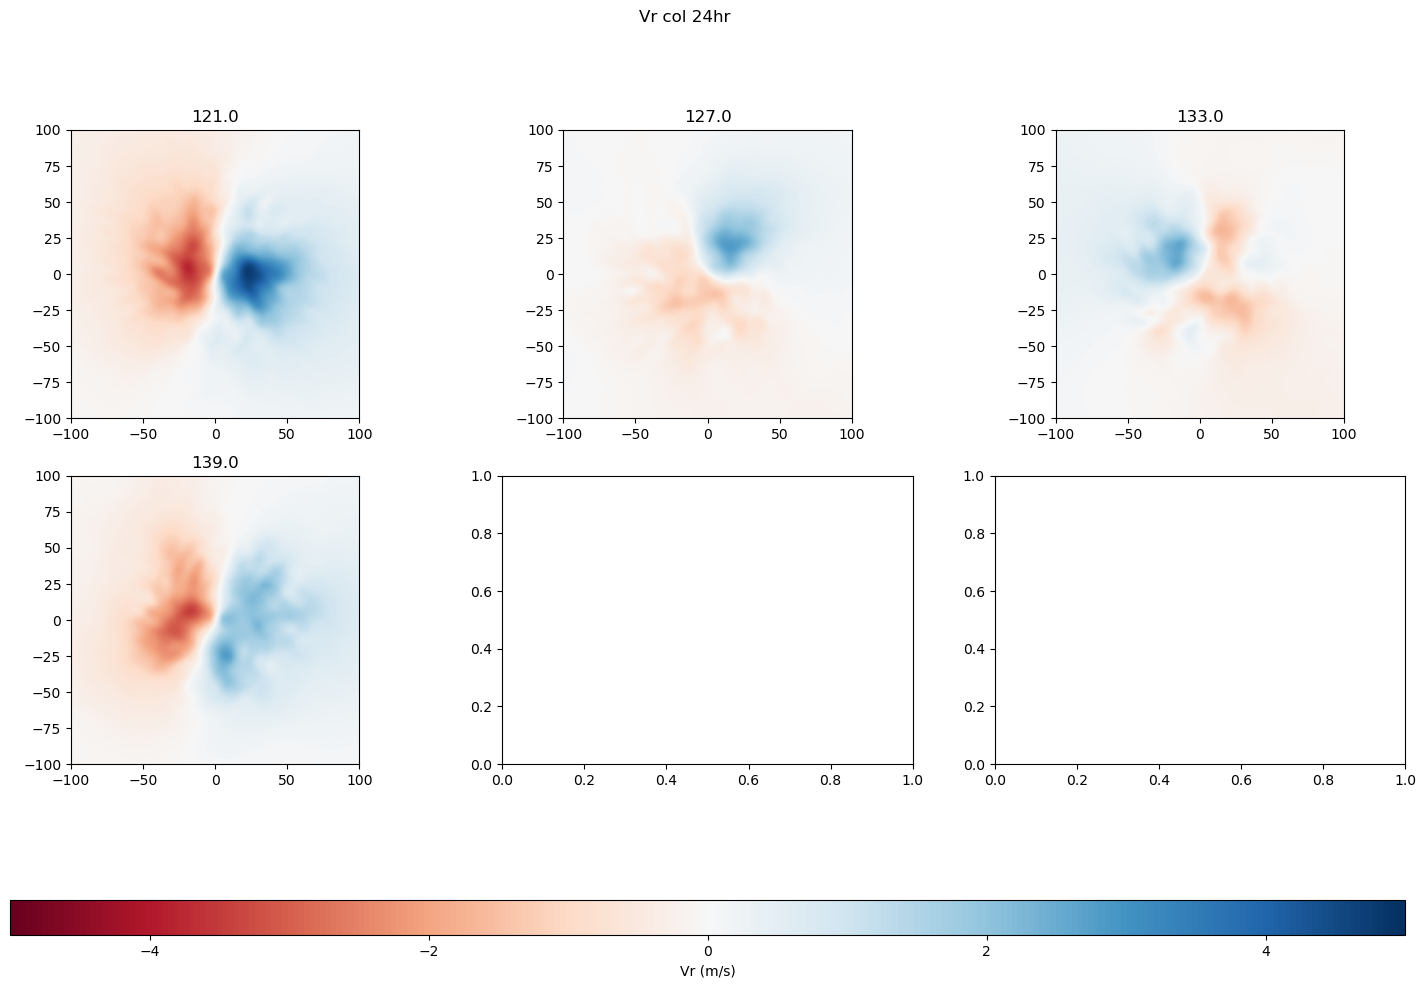

In [116]:
importlib.reload(wrf)
importlib.reload(gu)

# plot maps of vrcm

# vrmaps=[wrf.getWRF(run,fname,'vr',type='dpwcm',z='full',force=force) for fname in flist]
x,y=wrf.getCoords(run,flist[0],cc=False)

vrmapscc=[]
for fname in flist:
    vrmapscc.append(gu.resample2center(wrf.getWRF(run,fname,'vr',vtype='dpwsmcm',z='full',force=force),\
                                       wrf.getWRF(run,fname,'cc')))

vrmapsav,hrsa=gu.avg_list(vrmapscc,avgt,hrs)

fig,axs=plt.subplots(2,3,dpi=100,figsize=(18,12))

cr=5
xr=100
def plt_maps(ax,x,y,v):
    im=gu.imshowxy(x/1000,y/1000,v,ax=ax,cmap=plt.get_cmap('RdBu'))
    im.set_clim((-cr,cr))
    ax.set_xlim((-xr,xr))
    ax.set_ylim((-xr,xr))
    ax.set_aspect('equal','box')
    ax.set_title(str(hrsa[n]))
    return(im)

for n,v in enumerate(vrmapsav[0:6]):
    im=plt_maps(axs.flat[n],x,y,v)
    
fig.colorbar(im,ax=axs,orientation='horizontal',aspect=40,label='Vr (m/s)')
plt.suptitle('Vr col 24hr')

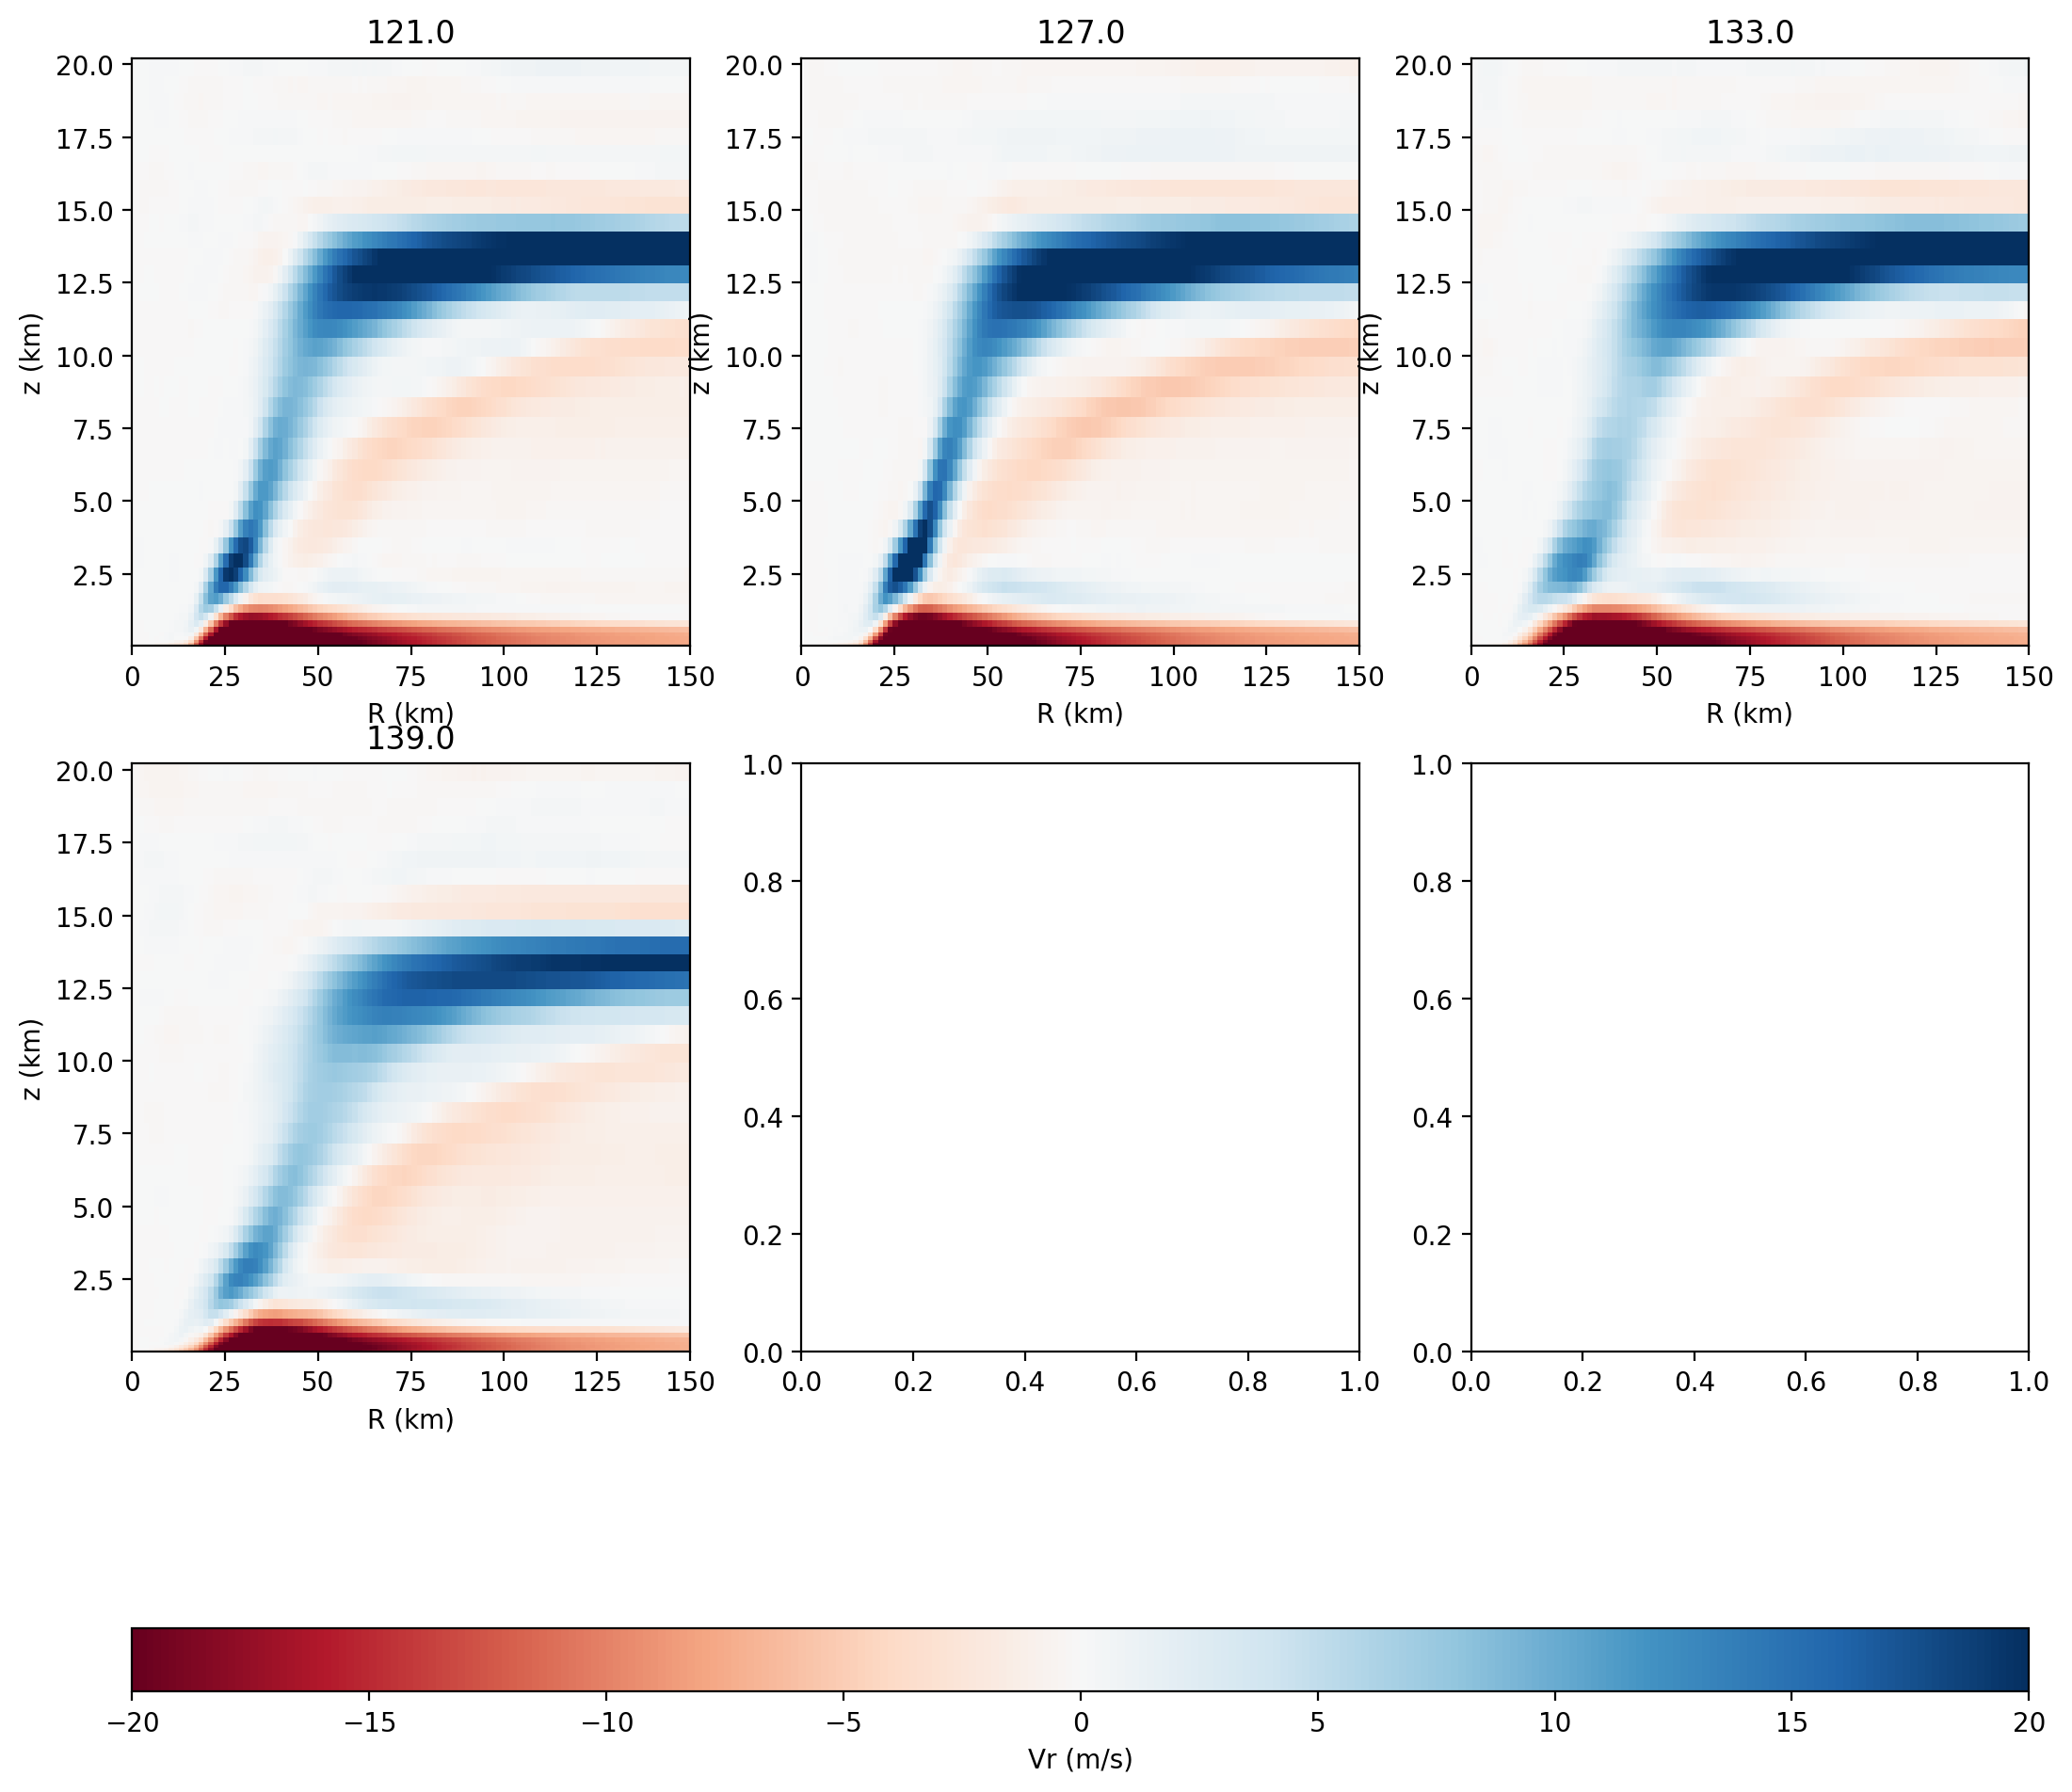

In [117]:
fig,axs=plt.subplots(2,3,figsize=(13,13),dpi=200)
cl=20

vrs=[wrf.getWRF(run,fname,'vr',z='full',vtype='az') for fname in flist]
vravs,hrsa=gu.avg_list(vrs,avgt,hrs)

for n,vr in enumerate(vravs[0:6]):
    ax=axs.flat[n]
    #vr=wrf.getWRF(run,fname,'vr',z='full',type='az')
    z=wrf.getHeightCoord(wrf.wopath(run,fname))
    r=wrf.getRcoord(wrf.wopath(run,fname))
    im=ax.pcolormesh(r,z[1:]/1000,vr.T,cmap=plt.get_cmap('RdBu'),shading='nearest')
    im.set_clim(-cl,cl)
    ax.set_xlim(0,150)
    ax.set_xlabel('R (km)')
    ax.set_ylabel('z (km)')
#     ax.text(10,18,fname)
    ax.set_title(str(hrsa[n]))
    
fig.colorbar(im,ax=axs,orientation='horizontal',aspect=30,label='Vr (m/s)')